# ISE-529, Final Project
Wednesday Section<br>
Rafael Blay (8746029470)<br>
Smita Bhat (8974118455)<br>
Xuejie Guo (7579682064)<br>
Zhiyun Zhang (6986706702)

In [1]:
# Kaggle Competition: Expedia Hotel Recommendations
# Link: https://www.kaggle.com/c/expedia-hotel-recommendations

In [2]:
# importing libraries
# basic libraries
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import random as rd
import datetime as dt

# data cleaning and processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

In [ ]:
# neural networks
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

In [3]:
# Code used to sample training data set

# # reading only part of data, since file is too big (over 4GB)
# filename = 'expedia-hotel-recommendations/train.csv'
# n = sum(1 for line in open(filename)) - 1 #num records (no header)
# s = 250000 # desired sample size
# rd.seed(42)
# skip = sorted(rd.sample(range(1,n+1),n-s)) #header not included
# df = pd.read_csv(filename, skiprows=skip)
# df.to_csv('expedia_training_sampled.csv',index=False)

In [4]:
df = pd.read_csv(
    'expedia-hotel-recommendations/expedia_training_sampled.csv')

In [5]:
df.shape

(250000, 31)

In [6]:
df.columns.values

array(['date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region',
       'user_location_city', 'orig_destination_distance', 'user_id',
       'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking',
       'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'book_period', 'site_name_new',
       'user_location_country_new', 'channel_new',
       'srch_destination_type_id_new', 'hotel_country_new',
       'hotel_market_new'], dtype=object)

## Feature Engineering

In [7]:
# Will combine srch_ci and srch_co
# Generate column named: book_period

In [8]:
df.srch_ci = pd.to_datetime(df.srch_ci,format = '%Y-%m-%d')
df.srch_co = pd.to_datetime(df.srch_co,format = '%Y-%m-%d')
temp_book_period = (df.srch_co - df.srch_ci)
temp_book_period = temp_book_period.fillna(0)
df['book_period'] = temp_book_period.dt.days.astype('int16')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  after removing the cwd from sys.path.


## Fixing Variable Types

In [9]:
df.dtypes

date_time                               object
site_name                                int64
posa_continent                           int64
user_location_country                    int64
user_location_region                     int64
user_location_city                       int64
orig_destination_distance              float64
user_id                                  int64
is_mobile                                int64
is_package                               int64
channel                                  int64
srch_ci                         datetime64[ns]
srch_co                         datetime64[ns]
srch_adults_cnt                          int64
srch_children_cnt                        int64
srch_rm_cnt                              int64
srch_destination_id                      int64
srch_destination_type_id                 int64
is_booking                               int64
cnt                                      int64
hotel_continent                          int64
hotel_country

In [10]:
# Some variables encoded as int should 
# be treated as object (categorical)

# Categorical Variables
# site_name
# posa_continent
# user_location_country
# user_location_region
# user_location_city
# channel
# hotel_continent
# hotel_country
# hotel_market
# hotel_cluster
# srch_destination_id
# srch_destination_type_id

In [11]:
df.site_name = df.site_name.astype('category')
df.posa_continent = df.posa_continent.astype('category')
df.user_location_country = df.user_location_country.astype(
    'category')
df.user_location_region = df.user_location_region.astype('category')
df.user_location_city = df.user_location_city.astype('category')
df.channel = df.channel.astype('category')
df.hotel_continent = df.hotel_continent.astype('category')
df.hotel_country = df.hotel_country.astype('category')
df.hotel_market = df.hotel_market.astype('category')
df.srch_destination_id = df.srch_destination_id.astype('category')
df.srch_destination_type_id = df.srch_destination_type_id.astype(
    'category')
df.hotel_cluster = df.hotel_cluster.astype('category')

In [12]:
df.dtypes

date_time                               object
site_name                             category
posa_continent                        category
user_location_country                 category
user_location_region                  category
user_location_city                    category
orig_destination_distance              float64
user_id                                  int64
is_mobile                                int64
is_package                               int64
channel                               category
srch_ci                         datetime64[ns]
srch_co                         datetime64[ns]
srch_adults_cnt                          int64
srch_children_cnt                        int64
srch_rm_cnt                              int64
srch_destination_id                   category
srch_destination_type_id              category
is_booking                               int64
cnt                                      int64
hotel_continent                       category
hotel_country

## Analyzing Categorical Variables

In [13]:
# site_name
temp_values = df.site_name.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'site_name').reset_index(name='percentage')
len(df_temp_values)

43

In [14]:
# site_name
temp_values = df.site_name.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'site_name').reset_index(name='percentage')
df_temp_values[:5]

,site_name,percentage
0,2,0.632756
1,11,0.069056
2,24,0.062504
3,37,0.053292
4,34,0.046920


In [15]:
# Around 60% of site_name is "2"
# Will change this to dummy variable (1 if site_name == 2 else 0)

In [16]:
# posa_continent
temp_values = df.posa_continent.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'posa_continent').reset_index(name='percentage')
len(df_temp_values)

5

In [17]:
df_temp_values[:5]

,posa_continent,percentage
0,3,0.750324
1,1,0.117844
2,2,0.093336
3,4,0.031696
4,0,0.006800


In [18]:
# Reasonable number of categories
# will keep it as is and convert to dummy for models

In [19]:
# user_location_country
temp_values = df.user_location_country.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'user_location_country').reset_index(name='percentage')
len(df_temp_values)

212

In [20]:
df_temp_values[:5]

,user_location_country,percentage
0,66,0.541852
1,205,0.110624
2,3,0.058420
3,69,0.051468
4,77,0.025276


In [21]:
# Too many categories
# Will likely keep top 4 most frequent categories and group
# other categories into "other"

In [22]:
# user_location_city
temp_values = df.user_location_city.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'user_location_city').reset_index(name='percentage')
len(df_temp_values)

15954

In [23]:
df_temp_values[:5]

,user_location_city,percentage
0,5703,0.019808
1,48862,0.016900
2,25315,0.010580
3,24103,0.010496
4,36086,0.009560


In [24]:
# Too many categories
# will likely drop this variable, since other 
# columns (such as user_location_country)
# have similar information in more condensed form

In [25]:
# user_location_region
temp_values = df.user_location_region.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'user_location_region').reset_index(name='percentage')
len(df_temp_values)

833

In [26]:
df_temp_values[:5]

,user_location_region,percentage
0,174,0.110608
1,348,0.050404
2,354,0.045136
3,442,0.038088
4,220,0.036024


In [27]:
# Too many categories
# will likely drop this variable, since other 
# columns (such as user_location_country)
# have similar information in more condensed form

In [28]:
# chanel
temp_values = df.channel.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'channel').reset_index(name='percentage')
len(df_temp_values)

11

In [29]:
df_temp_values[:11]

,channel,percentage
0,9,0.552112
1,0,0.124896
2,1,0.102760
3,2,0.078676
4,5,0.062248
5,3,0.044232
6,4,0.021876
7,7,0.008468
8,8,0.003028
9,6,0.001552


In [30]:
# Too many categories
# Will likely keep top 4 most frequent categories and group
# other categories into "other"

In [31]:
# srch_destination_id
temp_values = df.srch_destination_id.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'srch_destination_id').reset_index(name='percentage')
len(df_temp_values)

13552

In [32]:
df_temp_values[:5]

,srch_destination_id,percentage
0,8250,0.035312
1,8267,0.026696
2,8791,0.016108
3,8268,0.014156
4,8745,0.013228


In [33]:
# Too many categories
# will likely drop this variable, since 
# other columns (such as srch_destination_type_id)
# have similar information in more condensed form

In [34]:
# srch_destination_type_id
temp_values = df.srch_destination_type_id.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'srch_destination_type_id').reset_index(name='percentage')
len(df_temp_values)

8

In [35]:
df_temp_values[:8]

,srch_destination_type_id,percentage
0,1,0.619320
1,6,0.223456
2,3,0.072996
3,5,0.047496
4,4,0.033000
5,8,0.003624
6,7,0.000064
7,9,0.000044


In [36]:
# Too many categories
# Will likely keep top 4 most frequent categories and group
# other categories into "other"

In [37]:
# hotel_continent
temp_values = df.hotel_continent.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'hotel_continent').reset_index(name='percentage')
len(df_temp_values)

7

In [38]:
df_temp_values[:7]

,hotel_continent,percentage
0,2,0.523036
1,6,0.202332
2,3,0.130720
3,4,0.114760
4,0,0.018828
5,5,0.010320
6,1,0.000004


In [39]:
# Reasonable number of categories
# will keep it as is and convert to dummy for models

In [40]:
# hotel_country
temp_values = df.hotel_country.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'hotel_country').reset_index(name='percentage')
len(df_temp_values)

189

In [41]:
df_temp_values[:10]

,hotel_country,percentage
0,50,0.476908
1,8,0.050484
2,198,0.046128
3,105,0.036204
4,70,0.031644
5,204,0.028428
6,77,0.024816
7,182,0.023636
8,106,0.017096
9,144,0.015788


In [42]:
# Too many categories
# Will likely keep top 4 most frequent categories and group
# other categories into "other"

In [43]:
# hotel_market
temp_values = df.hotel_market.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'hotel_market').reset_index(name='percentage')
len(df_temp_values)

2004

In [44]:
# hotel_market
temp_values = df.hotel_market.value_counts()/len(df)
df_temp_values = temp_values.rename_axis(
    'hotel_market').reset_index(name='percentage')
df_temp_values[:20]

,hotel_market,percentage
0,628,0.046804
1,675,0.042400
2,682,0.022604
3,19,0.021184
4,365,0.020592
5,701,0.019804
6,110,0.019588
7,27,0.017016
8,1230,0.015944
9,212,0.013500


In [45]:
# Too many categories
# Will likely keep top 4 most frequent categories and group
# other categories into "other"

## Encoding Variables

In [46]:
# Will group categories and then create dummies

In [47]:
df['site_name_new'] = df[
    'site_name'].apply(
    lambda i: i if i in [2] else 'other')

df['user_location_country_new'] = df[
    'user_location_country'].apply(
    lambda i: i if i in [66,205,3,69] else 'other')

df['channel_new'] = df[
    'channel'].apply(
    lambda i: i if i in [9,0,1,2] else 'other')

df['srch_destination_type_id_new'] = df[
    'srch_destination_type_id'].apply(
    lambda i: i if i in [1,6,3,5] else 'other')

df['hotel_country_new'] = df[
    'hotel_country'].apply(
    lambda i: i if i in [50,8,198,105] else 'other')

df['hotel_market_new'] = df[
    'hotel_market'].apply(
    lambda i: i if i in [628,675,682,19] else 'other')

## Dropping Variables

In [48]:
# Columns to drop:
# - user_id (many unique values, can overfit)
# - orig_destination_distance (many NAs)
# - srch_ci (combined with srch_co into book_period)
# - srch_co (combined with srch_ci into book_period)
# - cnt (redundant column)
# - date_time (log data, can overfit)
# - site_name (replaced by site_name_new)
# - user_location_country (replaced by user_location_country_new)
# - user_location_city (related to user_location_country_new)
# - user_location_region (related to user_location_country_new)
# - channel (replaced by channel_new)
# - srch_destination_id (related to srch_destination_type_id_new)
# - srch_destination_type_id 
#    (replaced by srch_destination_type_id_new)
# - hotel_country (replaced by hotel_country_new)
# - hotel_market (replaced by hotel_market_new)
# - is_booking (not present on test set)

In [49]:
cols_to_drop = ['user_id','orig_destination_distance',
               'date_time','cnt','srch_co','srch_ci',
               'site_name','user_location_country',
                'user_location_city','user_location_region',
               'channel','srch_destination_id',
                'srch_destination_type_id','hotel_country',
                'hotel_market','is_booking']

In [50]:
df1 = df.drop(columns=cols_to_drop)
df1.shape

(250000, 15)

In [51]:
df1.dtypes

posa_continent                  category
is_mobile                          int64
is_package                         int64
srch_adults_cnt                    int64
srch_children_cnt                  int64
srch_rm_cnt                        int64
hotel_continent                 category
hotel_cluster                   category
book_period                        int16
site_name_new                     object
user_location_country_new         object
channel_new                       object
srch_destination_type_id_new      object
hotel_country_new                 object
hotel_market_new                  object
dtype: object

## Creating Dummy Variables

In [52]:
cols_to_dummy = ['posa_continent','hotel_continent','site_name_new',
                'user_location_country_new','channel_new',
                 'srch_destination_type_id_new',
                 'hotel_country_new','hotel_market_new'
                ]
df2 = pd.get_dummies(df1,columns=cols_to_dummy)
df2.shape

(250000, 46)

In [53]:
df2.dtypes

is_mobile                                int64
is_package                               int64
srch_adults_cnt                          int64
srch_children_cnt                        int64
srch_rm_cnt                              int64
hotel_cluster                         category
book_period                              int16
posa_continent_0                         uint8
posa_continent_1                         uint8
posa_continent_2                         uint8
posa_continent_3                         uint8
posa_continent_4                         uint8
hotel_continent_0                        uint8
hotel_continent_1                        uint8
hotel_continent_2                        uint8
hotel_continent_3                        uint8
hotel_continent_4                        uint8
hotel_continent_5                        uint8
hotel_continent_6                        uint8
site_name_new_2                          uint8
site_name_new_other                      uint8
user_location

## Separating Train-Test

In [54]:
X = df2.drop(columns=['hotel_cluster'])
y = df2.hotel_cluster

In [55]:
X_train0, X_test0, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

## Scaling Data

In [56]:
# only numeric columns (excluding dummy ones) need to be scaled
numeric_cols = ['srch_adults_cnt','srch_children_cnt',
                'srch_rm_cnt','book_period']

In [57]:
scaler = StandardScaler()

# scaler is fit only on training set
scaler.fit(X_train0[numeric_cols])

X_train = X_train0.copy()
X_test = X_test0.copy()

X_train[numeric_cols] = scaler.transform(X_train0[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## Feature Importance (Random Forest)

In [58]:
rf_0 = RandomForestClassifier(n_estimators=100,
                             random_state=1)
rf_0.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [59]:
importance_0 = pd.DataFrame(
    {'Importance':rf_0.feature_importances_*100},
    index=X_train.columns)
importance_0_sorted = importance_0.sort_values(
    by='Importance',axis=0,ascending=False)
importance_0_sorted

,Importance
book_period,32.225542
srch_adults_cnt,14.799996
srch_children_cnt,10.541117
is_mobile,5.129307
srch_rm_cnt,4.935198
is_package,3.212319
channel_new_9,2.773042
channel_new_other,2.159956
channel_new_0,2.097563
channel_new_1,2.066004


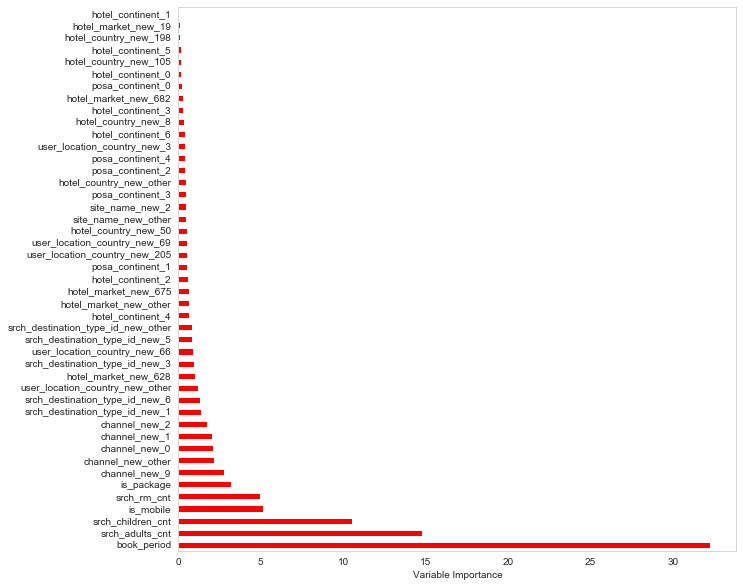

In [60]:
importance_0_sorted.plot(kind='barh',color='r',figsize=(10,10))
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.grid()

## Initial Single Value Accuracy (untuned RF)

In [61]:
rf_0_predictions = rf_0.predict(X_test)
rf_0_accuracy = accuracy_score(y_test,rf_0_predictions)
rf_0_accuracy

0.06145333333333333

## Initial Map@5 (top 5 values) Accuracy (untuned RF)

In [62]:
rf_probabilities = rf_0.predict_proba(X_test)
n = 5
top_n_rf_predictions = np.argsort(rf_probabilities)[:,:-n-1:-1]

df_rf_predictions = pd.DataFrame(
    data=top_n_rf_predictions,
    columns=['yhat1','yhat2','yhat3',
             'yhat4','yhat5'])
df_rf_predictions['y'] = y_test.values
df_rf_predictions['is_accurate'] = np.where(
    (
        (df_rf_predictions['y'] == df_rf_predictions['yhat1']) |
        (df_rf_predictions['y'] == df_rf_predictions['yhat2']) |
        (df_rf_predictions['y'] == df_rf_predictions['yhat3']) |
        (df_rf_predictions['y'] == df_rf_predictions['yhat4']) |
        (df_rf_predictions['y'] == df_rf_predictions['yhat5']) 
    ),1,0)
df_rf_predictions[:20]

map_at_5_accuracy_rf_0 = sum(
    df_rf_predictions.is_accurate)/len(df_rf_predictions)
map_at_5_accuracy_rf_0

0.21901333333333334

## MAP@5 Evaluation Function

In [63]:
# this competition uses the Map@5 function for evaluation
# essentially, checking if any of the top 5 predictions for 
# a cluster is accurate

In [64]:
def map_at_5_for_model(model):
    # generating top 5 probabilities
    model_probabilities = model.predict_proba(X_test)
    n = 5
    top_n_predictions = np.argsort(model_probabilities)[:,:-n-1:-1]
    
    # creating dataframe with 5 predictions and test value
    df_predictions = pd.DataFrame(
    data=top_n_predictions,
    columns=['yhat1','yhat2','yhat3',
             'yhat4','yhat5'])
    df_predictions['y'] = y_test.values
    
    # checking prediction accuracy
    df_predictions['is_accurate'] = np.where(
        (
            (df_predictions['y'] == df_predictions['yhat1']) |
            (df_predictions['y'] == df_predictions['yhat2']) |
            (df_predictions['y'] == df_predictions['yhat3']) |
            (df_predictions['y'] == df_predictions['yhat4']) |
            (df_predictions['y'] == df_predictions['yhat5']) 
        ),1,0)
    
    # calculating overall accuracy
    map_at_5_accuracy = sum(
        df_predictions.is_accurate)/len(df_predictions)
    return(map_at_5_accuracy)

## Dataframe for model comparison

In [65]:
temp_model_dict = {'model': ['untuned RF'],
                   'map_at_5_accuracy': [map_at_5_accuracy_rf_0]
                  }

In [66]:
df_model_comparison = pd.DataFrame(data = temp_model_dict,
                                  columns = ['model',
                                             'map_at_5_accuracy'])

## Logistic Regression 

In [67]:
lg = LogisticRegression(solver = 'lbfgs',multi_class='multinomial',
                        max_iter=10000)

lg1 = lg.fit(X_train, y_train)
y_pred = lg1.predict(X_test)

map_at_5_accuracy_lg = map_at_5_for_model(lg)
map_at_5_accuracy_lg

0.29212

In [68]:
temp_model_dict = {'model': 'Logistic Regression',
                   'map_at_5_accuracy': map_at_5_accuracy_lg
                  }
df_model_comparison = df_model_comparison.append(temp_model_dict,
                                                 ignore_index=True)

## Decision Tree

In [69]:
# parameter tuning
param = DecisionTreeClassifier()

bestparam={
           'criterion':['gini','entropy'],
           'max_depth':[3,6,9,12],
           'max_features':[3,6,9,12],
          }

def hypertuning_rscv(param, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(param, 
                                   param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, 
                                   cv=5)
    
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

hypertuning_rscv(param,bestparam , 40, X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


({'max_features': 9, 'max_depth': 9, 'criterion': 'gini'}, 0.08808571428571428)

In [70]:
tree = DecisionTreeClassifier(max_depth=9, 
                              criterion='entropy', 
                              max_features=12)
tree = tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
dt_accuracy = accuracy_score(y_pred,y_test)
dt_accuracy

0.08648

In [71]:
map_at_5_accuracy_dt = map_at_5_for_model(tree)
map_at_5_accuracy_dt

0.28130666666666665

In [72]:
temp_model_dict = {'model': 'Decision Tree',
                   'map_at_5_accuracy': map_at_5_accuracy_dt
                  }
df_model_comparison = df_model_comparison.append(temp_model_dict,
                                                 ignore_index=True)

## Random Forest (with Tuned Parameters)

In [73]:
n_estimators = [100,500]
param_grid = dict(n_estimators = n_estimators)
kfold = StratifiedKFold(n_splits = 2, shuffle=True, 
                        random_state = 1)
model = RandomForestClassifier()
grid_search = GridSearchCV(model,param_grid,
                           scoring = 'neg_log_loss',
                           cv=kfold)
grid_result = grid_search.fit(X_train,y_train)

In [74]:
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
df_rf = pd.DataFrame()
df_rf['params'] = params
df_rf['mean test score'] = means
df_rf[:2]

,params,mean test score
0,{'n_estimators': 100},-18.558545
1,{'n_estimators': 500},-15.996961


In [75]:
grid_result.best_score_

-15.996961351880545

In [76]:
grid_result.best_params_

{'n_estimators': 500}

In [77]:
rf_1 = grid_result.best_estimator_
rf_1_predictions = rf_1.predict(X_test)
rf_1_accuracy = accuracy_score(y_test,rf_1_predictions)
rf_1_accuracy

0.061893333333333335

In [78]:
map_at_5_accuracy_rf_1 = map_at_5_for_model(rf_1)
map_at_5_accuracy_rf_1

0.2214

In [79]:
temp_model_dict = {'model': 'tuned RF',
                   'map_at_5_accuracy': map_at_5_accuracy_rf_1
                  }
df_model_comparison = df_model_comparison.append(temp_model_dict,
                                                 ignore_index=True)

## XGBoost

In [80]:
rates = [0.01,0.3]

param_grid = dict(learning_rate = rates)
kfold = StratifiedKFold(n_splits = 2, shuffle=True, 
                        random_state = 1)

In [81]:
# low number os trees was used because computer could not handle more
model = XGBClassifier(n_estimators=10)
grid_search = GridSearchCV(model,param_grid,
                           scoring = 'neg_log_loss',
                           cv=kfold)
grid_result = grid_search.fit(X_train,y_train)

In [82]:
grid_result.best_params_

{'learning_rate': 0.3}

In [83]:
xgb = grid_result.best_estimator_

In [84]:
map_at_5_accuracy_xgb = map_at_5_for_model(xgb)
map_at_5_accuracy_xgb

0.2912266666666667

In [85]:
temp_model_dict = {'model': 'XGBoost',
                   'map_at_5_accuracy': map_at_5_accuracy_xgb
                  }
df_model_comparison = df_model_comparison.append(temp_model_dict,
                                                 ignore_index=True)

## KNN Classifier

In [86]:
n_neighbors = [21,71,121]
param_grid = dict(n_neighbors = n_neighbors)
kfold = StratifiedKFold(n_splits = 2, shuffle=True, 
                        random_state = 1)
model = KNeighborsClassifier()
grid_search = GridSearchCV(model,param_grid,
                           scoring = 'neg_log_loss',
                           cv=kfold)
grid_result = grid_search.fit(X_train,y_train)

In [87]:
grid_result.best_params_

{'n_neighbors': 121}

In [88]:
knn = grid_result.best_estimator_
knn_predictions = xgb.predict(X_test)
knn_accuracy = accuracy_score(y_test,knn_predictions)
knn_accuracy

0.08989333333333334

In [89]:
map_at_5_accuracy_knn = map_at_5_for_model(knn)
map_at_5_accuracy_knn

0.2636266666666667

In [90]:
temp_model_dict = {'model': 'KNN',
                   'map_at_5_accuracy': map_at_5_accuracy_knn
                  }
df_model_comparison = df_model_comparison.append(temp_model_dict,
                                                 ignore_index=True)

## Naive Bayes

In [91]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [92]:
map_at_5_accuracy_gnb = map_at_5_for_model(gnb)
map_at_5_accuracy_gnb

0.16714666666666667

temp_model_dict = {'model': 'Gaussian Naive Bayes',
                   'map_at_5_accuracy': map_at_5_accuracy_gnb
                  }
df_model_comparison = df_model_comparison.append(temp_model_dict,
                                                 ignore_index=True)

## Support Vector Classifiers

In [ ]:
# We tried to run a SVC model
# However it was too computational heavy for our laptop
# We also ran into issues with Google Collab (not enough RAM)

In [ ]:
kernel = ['rbf','sigmoid']
param_grid = dict(kernel = kernel)
kfold = StratifiedKFold(n_splits = 2, shuffle=True, 
                        random_state = 1)
model = SVC(verbose=2)
grid_search = GridSearchCV(model,param_grid,
                           scoring = 'neg_log_loss',
                           cv=kfold,verbose=2)
grid_result = grid_search.fit(X_train,y_train)
grid_result.best_params_
svc = grid_result.best_estimator_
svc_predictions = xgb.predict(X_test)
svc_accuracy = accuracy_score(y_test,svc_predictions)
svc_accuracy

## Neural Networks

In [ ]:
# We tried to run a neural network model
# However it was too computational heavy for our laptop
# We also ran into issues with Google Collab (not enough RAM)

In [ ]:
y = keras.utils.np_utils.to_categorical(y)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

X_train = keras.utils.normalize(X_train, axis=1)  
X_test = keras.utils.normalize(X_test, axis=1)

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=18))
model.add(Dropout(0.25))
model.add(Dense(256 , activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256 , activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(100, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_acc', mode='max', 
                   verbose=1, patience=50)

his = model.fit(X_train, y_train,  epochs=500, 
                batch_size=128, callbacks=[es])

## Selecting Best Model

In [94]:
df_model_comparison

,model,map_at_5_accuracy
0,untuned RF,0.219013
1,Logistic Regression,0.292120
2,Decision Tree,0.281307
3,tuned RF,0.221400
4,XGBoost,0.291227
5,KNN,0.263627
6,Gaussian Naive Bayes,0.167147


In [95]:
# Best model is Logistic Regression (MAP@5 of 29.3%)

## Reading Kaggle Submission (Test Set)

In [96]:
df = pd.read_csv(
    'expedia-hotel-recommendations/test.csv')

## Processing Kaggle Test Set 

In [97]:
df.srch_ci = pd.to_datetime(df.srch_ci,format = '%Y-%m-%d',
                           errors='coerce')
df.srch_co = pd.to_datetime(df.srch_co,format = '%Y-%m-%d',
                           errors='coerce')
temp_book_period = (df.srch_co - df.srch_ci)
temp_book_period = temp_book_period.fillna(0)
df['book_period'] = temp_book_period.dt.days.astype('int16')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  


In [98]:
df.site_name = df.site_name.astype('category')
df.posa_continent = df.posa_continent.astype('category')
df.user_location_country = df.user_location_country.astype(
    'category')
df.user_location_region = df.user_location_region.astype('category')
df.user_location_city = df.user_location_city.astype('category')
df.channel = df.channel.astype('category')
df.hotel_continent = df.hotel_continent.astype('category')
df.hotel_country = df.hotel_country.astype('category')
df.hotel_market = df.hotel_market.astype('category')
df.srch_destination_id = df.srch_destination_id.astype('category')
df.srch_destination_type_id = df.srch_destination_type_id.astype(
    'category')

In [99]:
df['site_name_new'] = df[
    'site_name'].apply(
    lambda i: i if i in [2] else 'other')

df['user_location_country_new'] = df[
    'user_location_country'].apply(
    lambda i: i if i in [66,205,3,69] else 'other')

df['channel_new'] = df[
    'channel'].apply(
    lambda i: i if i in [9,0,1,2] else 'other')

df['srch_destination_type_id_new'] = df[
    'srch_destination_type_id'].apply(
    lambda i: i if i in [1,6,3,5] else 'other')

df['hotel_country_new'] = df[
    'hotel_country'].apply(
    lambda i: i if i in [50,8,198,105] else 'other')

df['hotel_market_new'] = df[
    'hotel_market'].apply(
    lambda i: i if i in [628,675,682,19] else 'other')

In [100]:
cols_to_drop = ['user_id','orig_destination_distance',
               'date_time','srch_co','srch_ci',
               'site_name','user_location_country',
                'user_location_city','user_location_region',
               'channel','srch_destination_id',
                'srch_destination_type_id','hotel_country',
                'hotel_market','id']
df1 = df.drop(columns=cols_to_drop)

In [101]:
cols_to_dummy = ['posa_continent','hotel_continent','site_name_new',
                'user_location_country_new','channel_new',
                 'srch_destination_type_id_new',
                 'hotel_country_new','hotel_market_new'
                ]
df2 = pd.get_dummies(df1,columns=cols_to_dummy)

In [112]:
df2[numeric_cols] = scaler.transform(df2[numeric_cols])

In [148]:
df_test_probabilities = lg1.predict_proba(df2)
n = 5
top_n_df_predictions = np.argsort(
    df_test_probabilities)[:,:-n-1:-1]

df_test_predictions = pd.DataFrame(
    data=top_n_df_predictions,
    columns=['yhat1','yhat2','yhat3',
             'yhat4','yhat5'])

## Kaggle Submision csv

In [152]:
df_test_predictions['id'] = df['id']
df_test_predictions[
    'hotel_cluster'] = df_test_predictions.yhat1.map(str) +\
    " " + df_test_predictions.yhat2.map(str) +\
    " " + df_test_predictions.yhat3.map(str) +\
    " " + df_test_predictions.yhat4.map(str) +\
    " " + df_test_predictions.yhat5.map(str)

In [153]:
df_submission = df_test_predictions.drop(
    columns=['yhat1','yhat2','yhat3','yhat4','yhat5'])

In [156]:
df_submission.to_csv('kaggle_submission.csv',index=False)